<a href="https://colab.research.google.com/github/ms03831/parallelized-PSO-clustering/blob/dev/gpu_project_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# git repo setup

In [5]:
!apt-get install nvidia-cuda-toolkit
!pip3 install numba
!pip install wurlitzer
!pip install orca

Reading package lists... Done
Building dependency tree       
Reading state information... Done
nvidia-cuda-toolkit is already the newest version (9.1.85-3ubuntu1).
You might want to run 'apt --fix-broken install' to correct these.
The following packages have unmet dependencies:
 nvidia-cuda-toolkit : Depends: nvidia-cuda-dev (= 9.1.85-3ubuntu1) but it is not going to be installed
E: Unmet dependencies. Try 'apt --fix-broken install' with no packages (or specify a solution).


In [6]:
%cd /content
#!rm parallelized-PSO-clustering -r
!git clone https://ms03831:hahaha:D1985764@github.com/ms03831/parallelized-PSO-clustering
!git config --global user.email "ms03831@st.habib.edu.pk"
!git config --global user.name "ms03831"

/content
fatal: destination path 'parallelized-PSO-clustering' already exists and is not an empty directory.


In [7]:
%cd /content/parallelized-PSO-clustering/
%cd Code/
%cd final

/content/parallelized-PSO-clustering
/content/parallelized-PSO-clustering/Code
/content/parallelized-PSO-clustering/Code/final


In [ ]:
!git pull
%cd /content/parallelized-PSO-clustering/
!git add .
!git commit -m "all files updated"
!git push origin main

Already up to date.
/content/parallelized-PSO-clustering
On branch dev
Your branch is up to date with 'origin/dev'.

nothing to commit, working tree clean
error: src refspec main does not match any.
error: failed to push some refs to 'https://ms03831:hahaha:D1985764@github.com/ms03831/parallelized-PSO-clustering'


# Demo

## Setup 

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random
import numpy as np
import random 
import importlib
from pso_utils import initializePoints, getPointsFromDataDigits, getPointsFromDataIris

In [9]:
#seeding and data generation
random_state = 20
np.random.seed(random_state)
random.seed(random_state)

K = 3 #number of clusters
N = 200 #number of points
points = initializePoints(N, K)

#benchmark datasets
points, labels, K = getPointsFromDataDigits() #mnist 
points3, labels, K3 = getPointsFromDataIris() #iris

In [10]:
#writing the config file to be used in shared memory
#as shared memory array only uses constants 
%%writefile config.py 
BLOCKDIM = 64
DATADIM = 2

Overwriting config.py


In [11]:
#reloaindg config file
import config; importlib.reload(config)

<module 'config' from '/content/parallelized-PSO-clustering/Code/final/config.py'>

## PSO

### There are multiple implementations of the pso module, the cells that follow run them all one by one and then validate their results

In [12]:
# loading all pso modules
import pso_cpu, pso_gpu_shared_memory, pso_utils, pso_gpu_simple, pso_gpu_update, pso_gpu_grid_stride

importlib.reload(pso_cpu)
importlib.reload(pso_utils)
importlib.reload(pso_gpu_simple)
importlib.reload(pso_gpu_update)
importlib.reload(pso_gpu_grid_stride)
importlib.reload(pso_gpu_shared_memory)

<module 'pso_gpu_shared_memory' from '/content/parallelized-PSO-clustering/Code/final/pso_gpu_shared_memory.py'>

In [13]:
# PSO parameters
particles = 30
iterations = 100
w = 0.99
c1 = 0.15
c2 = 0.2
BLOCKDIM = 64
DATADIM = 2

### CPU

In [14]:
#run algo and save centroids for plotting later
cpu_centroids = pso_cpu.main(   points, K, random_state, DATADIM, 
                            BLOCKDIM, particles, iterations, 
                            w, c1, c2   )
print("CPU")

CPU


### GPU Naive

In [15]:
gpu_centroids1 = pso_gpu_simple.main(   points, K, random_state, DATADIM, 
                            BLOCKDIM, particles, iterations, 
                            w, c1, c2   )
print("GPU Naive")

GPU Naive


### GPU Shared Memory

In [16]:
gpu_centroids2 = pso_gpu_shared_memory.main(   points, K, random_state, DATADIM, 
                            BLOCKDIM, particles, iterations, 
                            w, c1, c2   )
print("GPU Shared Memory")

GPU Shared Memory


### GPU Update Parallel

In [17]:
gpu_centroids3 = pso_gpu_update.main(   points, K, random_state, DATADIM, 
                            BLOCKDIM, particles, iterations, 
                            w, c1, c2   )
print("GPU Update Parallel")

GPU Update Parallel


### GPU Grid Stride

In [18]:
gpu_centroids4 = pso_gpu_grid_stride.main(   points, K, random_state, DATADIM, 
                            BLOCKDIM, particles, iterations, 
                            w, c1, c2   )
print("GPU Grid Stride")

GPU Grid Stride


### Validation

In [19]:
print("Naive Implementation Validated")
assert np.allclose(cpu_centroids, gpu_centroids1)
print("Update Parallel Implementation Validated")
assert np.allclose(cpu_centroids, gpu_centroids3)
print("GridStride Implementation Validated")
assert np.allclose(cpu_centroids, gpu_centroids4)
print("Shared Memory Implementation Validated")
assert np.allclose(cpu_centroids, gpu_centroids2)

Naive Implementation Validated
Update Parallel Implementation Validated
GridStride Implementation Validated
Shared Memory Implementation Validated


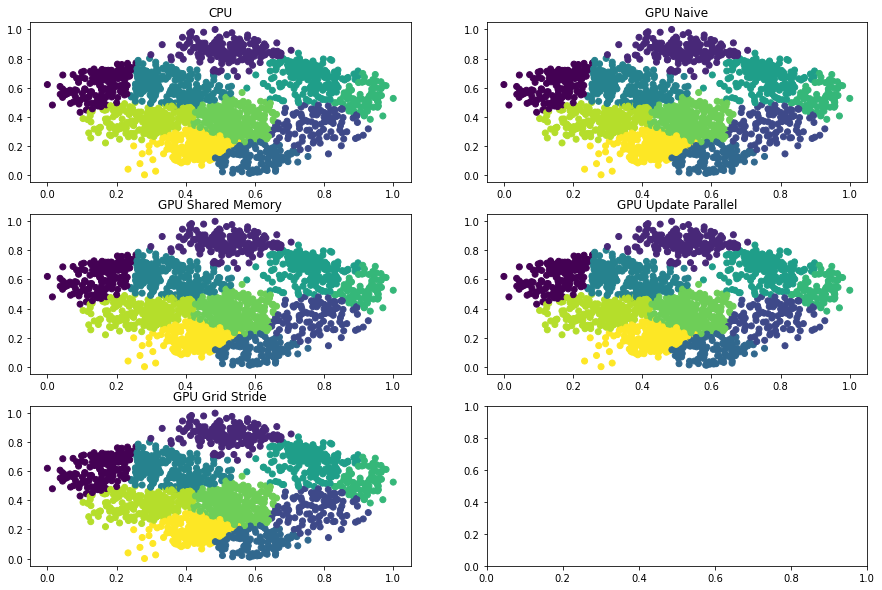

In [20]:
# Visual Validation
fig, subs = plt.subplots(3, 2, figsize=(15,10))

subs[0][0].scatter(*zip(*points), c = cpu_centroids)
subs[0][0].set_title('CPU')

subs[0][1].scatter(*zip(*points), c = gpu_centroids1)
subs[0][1].set_title('GPU Naive')

subs[1][0].scatter(*zip(*points), c = gpu_centroids2)
subs[1][0].set_title('GPU Shared Memory')

subs[1][1].scatter(*zip(*points), c = gpu_centroids3)
subs[1][1].set_title('GPU Update Parallel')

subs[2][0].scatter(*zip(*points), c = gpu_centroids4)
subs[2][0].set_title('GPU Grid Stride')

plt.show()

## Kmeans

In [26]:
#loading modules
!git pull
import kmeans_cpu; 
import kmeans_gpu
importlib.reload(kmeans_cpu)
importlib.reload(kmeans_gpu)

remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.
From https://github.com/ms03831/parallelized-PSO-clustering
   ed157de..ed09f0c  dev        -> origin/dev
Updating ed157de..ed09f0c
Fast-forward
 Code/final/kmeans_cpu.py | 7 ++++---
 Code/final/kmeans_gpu.py | 3 ++-
 2 files changed, 6 insertions(+), 4 deletions(-)


<module 'kmeans_gpu' from '/content/parallelized-PSO-clustering/Code/final/kmeans_gpu.py'>

### CPU

/content/parallelized-PSO-clustering/Code/final/kmeans_cpu.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(clusters), np.array(centroids)


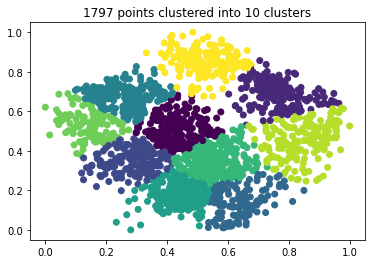

The score of our CPU K-means clustering is: 15.4829


/content/parallelized-PSO-clustering/Code/final/kmeans_cpu.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  distances = np.array([clusters[i] - centroids[i] for i in range(len(clusters))])


In [29]:
from kmeans_cpu import main_kmeans_cpu
#get centroid colors
colors, clusters, centroids = main_kmeans_cpu(points, K, random_state, visuals = False)
plt.scatter(points[:, 0], points[:, 1], c = colors)
plt.title("{0} points clustered into {1} clusters".format(len(points), K))
plt.show()
print ("The score of our CPU K-means clustering is:", round(kmeans_cpu.clusterQuality(points, clusters, centroids), 4))

### GPU

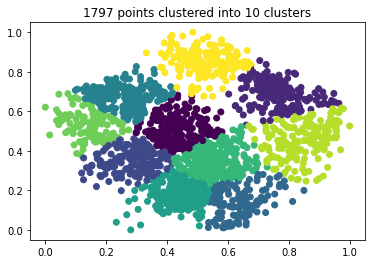

The score of our GPU K-means clustering is: 15.4829


In [28]:
from kmeans_gpu import main_kmeans_gpu
clusters, centroids = main_kmeans_gpu(points, K, random_state, visuals = False)
plt.scatter(points[:, 0], points[:, 1], c = clusters)
plt.title("{0} points clustered into {1} clusters".format(len(points), K))
plt.show()
print ("The score of our GPU K-means clustering is:", round(kmeans_gpu.clusterQuality(points, clusters, centroids), 4))

### sklearn

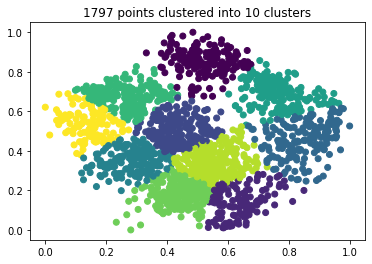

The score of sklearn Kmeans clustering is: 15.4787


In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=K, random_state=random_state).fit(points)
y_predict = kmeans.predict(points)

plt.scatter(points[:, 0], points[:, 1], c = y_predict)
plt.title(f"{len(points)} points clustered into {K} clusters")
plt.show()    
print(f"The score of sklearn Kmeans clustering is: {round(np.abs(kmeans.score(points)), 4)}")

### validation

In [31]:
print("GPU Implementation Validated")
assert np.allclose(cpu_centroids, gpu_centroids1)
print("Sklearn Implementation Validated")
assert np.allclose(cpu_centroids, gpu_centroids3)

GPU Implementation Validated
Sklearn Implementation Validated


## PSO - Kmeans Hybrid
- This section presents just one combination that worked best - kmeans and pso with update parallelized and gridstride -

In [38]:
#loading
#!git pull
%cd /content/parallelized-PSO-clustering/Code/final/integrated 
import pso_then_kmeans_gpu
importlib.reload(pso_then_kmeans_gpu) 

/content/parallelized-PSO-clustering/Code/final/integrated


<module 'pso_then_kmeans_gpu' from '/content/parallelized-PSO-clustering/Code/final/integrated/pso_then_kmeans_gpu.py'>

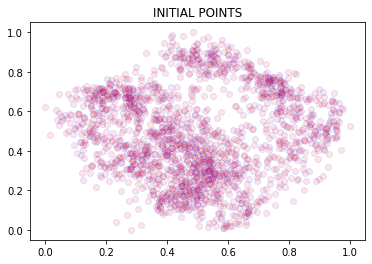

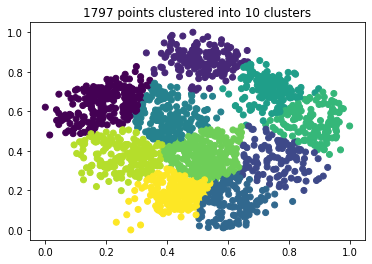

The score of best Kmeans clustering is: 15.919024727056259
time taken: 3.640904664993286


In [39]:
pso_then_kmeans_gpu.main(   points, K, random_state, DATADIM, 
                BLOCKDIM, particles, iterations, 
                w, c1, c2   )

## Analysis
- Just a sneak peak into the analysis that we did, extended analysis is in a separate notebook

In [42]:
%cd /content/parallelized-PSO-clustering/Code/allgraphs
import pandas as pd
from matplotlib import pyplot as plt
#read all csv files
cpu = pd.read_csv("CPU.csv")
gpu_simple = pd.read_csv("GPU_simple.csv")
gpu_update = pd.read_csv("GPU_update.csv")
gpu_grid = pd.read_csv("GPU_gridstride.csv")
gpu_sm = pd.read_csv("GPU_sharedmem.csv")

/content/parallelized-PSO-clustering/Code/allgraphs


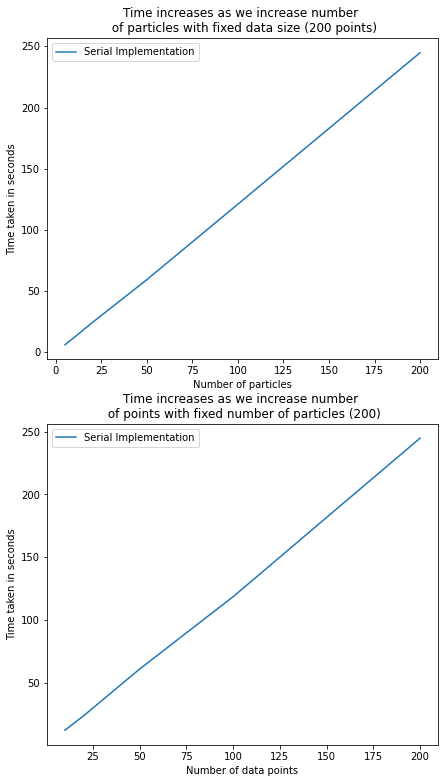

In [46]:
fixed_n_cpu = cpu.loc[(cpu["n"] == 200) & (cpu["particles"] <= 200)]
fixed_particles_cpu = cpu.loc[(cpu["particles"] == 200) & (cpu["n"] <= 200)]

cpu1 = fixed_n_cpu[["particles", "totalTime"]].to_numpy()
cpu2 = fixed_particles_cpu[["n", "totalTime"]].to_numpy()

fig = plt.figure(figsize = (7, 13))
plt.subplot(2, 1, 1)
plt.plot(cpu1[:, 0], cpu1[:, 1], "-", label = "Serial Implementation")
plt.legend()
plt.title("Time increases as we increase number \n of particles with fixed data size (200 points)")
plt.xlabel("Number of particles")
plt.ylabel("Time taken in seconds")

plt.subplot(2, 1, 2)
plt.plot(cpu2[:, 0], cpu2[:, 1], "-", label = "Serial Implementation")
plt.legend()
plt.title("Time increases as we increase number \n of points with fixed number of particles (200)")
plt.xlabel("Number of data points")
plt.ylabel("Time taken in seconds")

plt.show()

In [47]:
fixed_n_gpu = gpu_simple.loc[(gpu_simple["n"] == 200) & (gpu_simple["particles"] <= 200)].reset_index(drop=True)
fixed_particles_gpu = gpu_simple.loc[(gpu_simple["n"] <= 200) & (gpu_simple["particles"] == 200)].reset_index(drop=True)

fixed_n_gpu1 = gpu_simple.loc[(gpu_simple["n"] == 200)].reset_index(drop=True)
fixed_particles_gpu1 = gpu_simple.loc[(gpu_simple["particles"] == 200)].reset_index(drop=True)

fixed_n_gpu2 = gpu_sm.loc[(gpu_sm["n"] == 200)].reset_index(drop=True)
fixed_particles_gpu2 = gpu_sm.loc[(gpu_sm["particles"] == 200)].reset_index(drop=True)

fixed_n_gpu3 = gpu_grid.loc[(gpu_grid["n"] == 200)].reset_index(drop=True)
fixed_particles_gpu3 = gpu_grid.loc[(gpu_grid["particles"] == 200)].reset_index(drop=True)

fixed_n_gpu4 = gpu_update.loc[(gpu_update["n"] == 200)].reset_index(drop=True)
fixed_particles_gpu4 = gpu_update.loc[(gpu_update["particles"] == 200)].reset_index(drop=True)

gpun = fixed_n_gpu[["particles", "totalTime"]].to_numpy()
gpup = fixed_particles_gpu[["n", "totalTime"]].to_numpy()

gpu1n = fixed_n_gpu1[["particles", "totalTime"]].to_numpy()
gpu1p = fixed_particles_gpu1[["n", "totalTime"]].to_numpy()

gpu2n = fixed_n_gpu2[["particles", "totalTime"]].to_numpy()
gpu2p = fixed_particles_gpu2[["n", "totalTime"]].to_numpy()

gpu3n = fixed_n_gpu3[["particles", "totalTime"]].to_numpy()
gpu3p = fixed_particles_gpu3[["n", "totalTime"]].to_numpy()

gpu4n = fixed_n_gpu4[["particles", "totalTime"]].to_numpy()
gpu4p = fixed_particles_gpu4[["n", "totalTime"]].to_numpy()

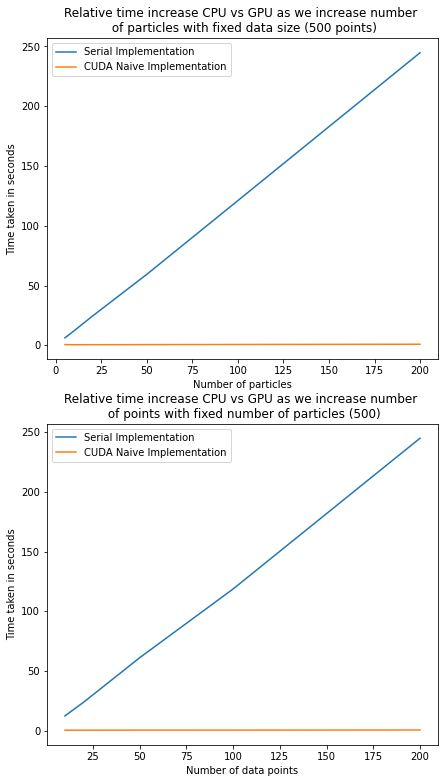

In [51]:
fig = plt.figure(figsize = (7, 13))
plt.subplot(2, 1, 1)
plt.plot(cpu1[:, 0], cpu1[:, 1], "-", label = "Serial Implementation")
plt.plot(gpun[:, 0], gpun[:, 1], "-", label = "CUDA Naive Implementation")
plt.legend()
plt.title("Relative time increase CPU vs GPU as we increase number \n of particles with fixed data size (500 points)")
plt.xlabel("Number of particles")
plt.ylabel("Time taken in seconds")

plt.subplot(2, 1, 2)
plt.plot(cpu2[:, 0], cpu2[:, 1], "-", label = "Serial Implementation")
plt.plot(gpup[:, 0], gpup[:, 1], "-", label = "CUDA Naive Implementation")
plt.legend()
plt.title("Relative time increase CPU vs GPU as we increase number \n of points with fixed number of particles (500)")
plt.xlabel("Number of data points")
plt.ylabel("Time taken in seconds")
plt.show()

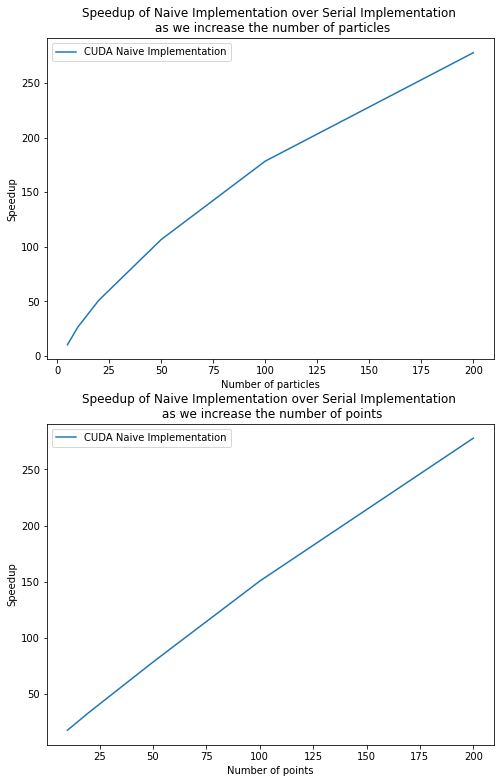

In [52]:
fig = plt.figure(figsize = (8, 13))
plt.subplot(2, 1, 1)
plt.plot(gpun[:, 0], np.round(cpu1[:, 1]/gpun[:, 1], 4), "-", label = "CUDA Naive Implementation")
plt.legend()
plt.title("Speedup of Naive Implementation over Serial Implementation \n as we increase the number of particles")
plt.xlabel("Number of particles")
plt.ylabel("Speedup")

plt.subplot(2, 1, 2)
plt.plot(gpup[:, 0], np.round(cpu2[:, 1]/gpup[:, 1], 4), "-", label = "CUDA Naive Implementation")
plt.legend()
plt.title("Speedup of Naive Implementation over Serial Implementation \n as we increase the number of points")
plt.xlabel("Number of points")
plt.ylabel("Speedup")
plt.show()